# Introduction
This study explores the dataset made available for the competition<br>
**Hackathon 3.x - Predict customer worth for Happy Customer Bank**<br>
organised by _Analytics Vidhya_ in 2015.<br>

For more information follow the link below:<br>
https://discuss.analyticsvidhya.com/t/hackathon-3-x-predict-customer-worth-for-happy-customer-bank/3802

### **Problem** _(as described in challange)_

''Digital arms of banks today face challenges with lead conversion, they source leads through mediums like search, display, email campaigns and via affiliate partners. Here Happy Customer Bank faces same challenge of low conversion ratio. They have given a problem to identify the customers segments having higher conversion ratio for a specific loan product so that they can specifically target these customers, here they have provided a partial data set for salaried customers only from the last 3 months. They also capture basic details about customers like gender, DOB, existing EMI, employer Name, Loan Amount Required, Monthly Income, City, Interaction data and many others. Let’s look at the process at Happy Customer Bank.''

### **Goal**

Predict the probability of disbursal for test data set.

## Table of Contents

1. **[Data preprocessing](#first-bullet)**
2. **[Modelling](#second-bullet)**

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wikipedia
import re
from bs4 import BeautifulSoup
import seaborn as sns
import pickle

## Loading the data

In [2]:
FILE = r'Data/Train_nyOWmfK.csv'
data = pd.read_csv(FILE, encoding='latin1')
data.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,...,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0
3,ID000008I30,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,...,NaN,NaN,NaN,N,Web-browser,B,S143,3,0,0
4,ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,...,NaN,NaN,NaN,N,Web-browser,B,S134,3,1,0


In [3]:
X, y = data.drop(["Disbursed"], axis=1), data.Disbursed

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=20, stratify=y)

# 1. Data preprocessing <a class="anchor" id="first-bullet"></a>

## Creating dictionaries

### Wikipedia scraping

In [5]:
def wiki_table_scraper(title, table_num=0, header=True):
    wikipedia.set_lang("en")
    page = wikipedia.page(title=title).html()
    soup = BeautifulSoup(page, 'html')
    table = soup.find_all('table', {'class':"wikitable sortable"})[table_num]
    head = False
    if header:
        trs = table.find_all('tr')[1:]
        head = [line.text.strip() for line in table.find_all('tr')[0].find_all('th')]
    else:
        trs = table.find_all('tr')
    
    table_list = [[n.text.strip() for n in line.find_all('td')] for line in trs]
    result = pd.DataFrame(data=table_list, columns=head)
    return result

#### Assigning state to particular city
**1st approach:** _Retrieving information from the Indian population table_

In [6]:
def match_state():
    city_state = wiki_table_scraper('List_of_cities_in_India_by_population')
    city_state.City = city_state.City.apply(lambda x: re.search(r'[\w]+', x).group())
    city_state.iloc[:,4] = city_state.iloc[:,4].apply(lambda x: re.search(r'[\w ]+', x).group())
    state_dict = city_state.set_index(city_state.iloc[:,1]).iloc[:,4].to_dict()
    return state_dict

**2nd approach:** _Search for specific queries_  >>>  _(Filling in the missing information for cities not included in the table.)_

In [7]:
def unmatched(df, match_dict, key):
    non_match = df[~df[key].isin(match_dict.keys())][key].value_counts().index
    return non_match

In [8]:
def match_state_complex(state_names, unmatched, a_sugg=False):    
    matching = {}
    for name in unmatched:
        try:
            page_key = wikipedia.search(f'{name} india')[0]
            page_summary = wikipedia.page(page_key, auto_suggest=a_sugg).summary
            matching[name] = page_summary
        except:
            pass
    match_df = pd.DataFrame.from_dict(matching, orient='index')
    match_df.index
    
    matching_states = {}
    for ix in match_df.index:
        try:
            for word in (match_df.loc[ix, 0]).split():
                if word in state_names:
                    correct_state = word
                    break
            matching_states[ix] = correct_state
        except:
            pass
    return matching_states

#### Assigning GDPs to states

In [9]:
def match_state_GDP():
    gdpS = wiki_table_scraper('List_of_Indian_states_and_union_territories_by_GDP')
    gdpS.iloc[:,2] = gdpS.iloc[:,2].apply(lambda x: re.search(r'\d+.\d+ la', x).group()[:-3]).map(float)
    state_to_gdp = gdpS.set_index(gdpS.iloc[:,1]).iloc[:,2].to_dict()
    return state_to_gdp

#### Assigning population count to cities

In [10]:
def match_population():
    city_table = wiki_table_scraper('List_of_cities_in_India_by_population')
    city_table.City = city_table.City.apply(lambda x: re.search(r'[\w]+', x).group())
    city_table.iloc[:,2] = city_table.iloc[:,2].apply(lambda x: x.replace(',','')).map(int)
    city_pop_dict = city_table.set_index(city_table.iloc[:,1]).iloc[:,2].to_dict()
    return city_pop_dict

In [11]:
def create_dictionaries(dataframe):
#     city_to_state = match_state()
#     states = set(city_to_state.values()) # set of India's states for further use

#     non_matched = unmatched(dataframe, city_to_state, 'City')
#     city_to_state.update(match_state_complex(states, non_matched))
    
    #------------------------------------------------
    # with open('city_to_state.pkl', 'wb') as f:
    #         pickle.dump(city_to_state, f)

    with open('city_to_state.pkl', 'rb') as f:
            city_to_state = pickle.load(f)
    #------------------------------------------------
    states = set(city_to_state.values())
    
    non_matched = unmatched(dataframe, city_to_state, 'City')
    city_to_state.update(match_state_complex(states, non_matched, a_sugg=True))

    states_not_matched = unmatched(dataframe, city_to_state, 'City')
    
    GDP_dict = match_state_GDP()
    city_population = match_population()
    
    # Creating City Rank with first 20 cities sorted by most frequent occurrence in the data
    city_rank_keys = dataframe.City.value_counts()[:20].keys()
    
    # Creating Employer Rank with first 15 Employers sorted by most frequent occurrence in the data
    employer_rank_keys = dataframe.Employer_Name[dataframe.Employer_Name!='0'].value_counts()[:15].keys()
    
    return city_to_state, GDP_dict, city_population, city_rank_keys, employer_rank_keys, states_not_matched

#### Monthly Income
Cutting part of the outliers with substitution to the maximum value _100 000_ (this value is still over upper IQR bound)

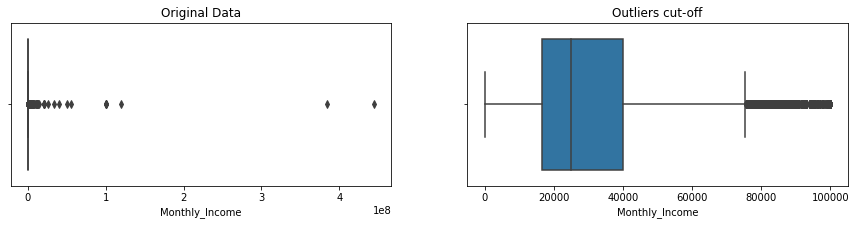

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15,3))

sns.boxplot(x=X_train.Monthly_Income, ax=axs[0])
axs[0].title.set_text("Original Data")
sns.boxplot(x=X_train.Monthly_Income.where(X_train.Monthly_Income < 100000, other=100000), ax=axs[1])
axs[1].title.set_text("Outliers cut-off")

plt.show()

In [13]:
# dictionaries = create_dictionaries(X_train)

# with open('dictionaries.pkl', 'wb') as f:
#     pickle.dump(dictionaries, f)

with open('dictionaries.pkl', 'rb') as f:
    dictionaries = pickle.load(f)
        
to_state, GDPs, population, city_rank, employer_rank_keys, states_not_matched = dictionaries

There are a few cities with no state assigned - for the purpose of simplicity they will be ignored in this study:

In [14]:
print(X_train[X_train.City.isin(states_not_matched)].City.value_counts())
print('\nMissing', X_train[X_train.City.isin(states_not_matched)].City.count(), 'values.')

AHMEDB                  9
Janigir - Champa        7
Proddattur              5
Pontashaib              5
Kamrup Metropolitian    3
DHANGARDHA              3
Banaskhantha            3
SURENDERNAGAR           3
Sonepur                 2
SOMNATH JUNAGADHA       1
Chinnamiram             1
Surendra Nagar          1
Name: City, dtype: int64

Missing 43 values.


In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names]
    def get_feature_names(self):
        return self.attribute_names

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

In [17]:
class CatDictionaries(BaseEstimator, TransformerMixin):
    def __init__(self, state, city_rank, emp_rank):
        self.state = state
        self.city_rank = city_rank
        self.emp_rank = emp_rank
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        self.feature_columns = ['State', 'City_rank', 'Employer_rank']
        df = pd.DataFrame(columns=self.feature_columns)
        df.State = X.City.map(self.state)
        df.City_rank = X.City.where(X.City.isin(self.city_rank), other='other')
        
        df.Employer_rank = X.Employer_Name.where(X.Employer_Name.isin(self.emp_rank), other='other')
        return df
    def get_feature_names(self):
        return self.feature_columns
    
class NumDictionaries(BaseEstimator, TransformerMixin):
    def __init__(self, state, gpd, population):
        self.state = state
        self.gpd = gpd
        self.population = population
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        self.feature_columns = ['StateGDP','City_population']
        df = pd.DataFrame(columns=self.feature_columns)
        df.StateGDP = X.City.map(self.state).map(self.gpd).map(float)
        df.City_population = X.City.map(self.population)
        return df
    def get_feature_names(self):
        return self.feature_columns

#### Dates processing

In [18]:
class DateFix(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        self.feature_columns = ['Age_at_lead']
        df = pd.DataFrame(columns=self.feature_columns)
        df.Age_at_lead = pd.to_datetime(X['Lead_Creation_Date'], format='%d-%b-%y').dt.year - pd.to_datetime(X['DOB'], format='%d-%b-%y').dt.year
        df.Age_at_lead = df['Age_at_lead'].where(df['Age_at_lead'] > 0, df['Age_at_lead'] + 100)
        df.Age_at_lead = np.log(1+df.Age_at_lead)
        return df
    def get_feature_names(self):
        return self.feature_columns

In [19]:
class Money(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = None
    def fit(self, X, y=None):
        for_impute = X[['Monthly_Income', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee']]
        imputer = KNNImputer(n_neighbors=2)
        self.imputer = imputer.fit(for_impute.dropna(how='any').sample(n=500))
        return self
    def transform(self, X, y=None):
        self.feature_columns = ['Monthly_Income', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate', 
                                'Processing_Fee', 'EMI_sub_calc', 'EMI_Income_tot_ratio', 'EMI_sub_Income_ratio']
        df = pd.DataFrame(columns=self.feature_columns) #, 'Loan_Amount_Applied', 'Loan_Tenure_Applied'])
        df.Monthly_Income = X.Monthly_Income.where(X.Monthly_Income < 100000, other=100000)
        for_impute = X[['Monthly_Income', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee']]
        imputed = self.imputer.transform(for_impute)
        df.Loan_Amount_Submitted = pd.DataFrame(imputed, index=for_impute.index)[1]
        df.Loan_Tenure_Submitted = pd.DataFrame(imputed, index=for_impute.index)[2]
        df.Interest_Rate = pd.DataFrame(imputed, index=for_impute.index)[3]
        df.Processing_Fee = pd.DataFrame(imputed, index=for_impute.index)[4]
       
        # creating additional columns: EMI calculated and EMI/Income ratios
        EMI_P = df.Loan_Amount_Submitted
        EMI_R = df.Interest_Rate/12/100
        EMI_N = df.Loan_Tenure_Submitted*12

        df.EMI_sub_calc = (EMI_P * EMI_R * (1 + EMI_R)**EMI_N) / ((1 + EMI_R)**EMI_N - 1)
        df.EMI_Income_tot_ratio = (X.Existing_EMI + df.EMI_sub_calc) / X.Monthly_Income
        df.EMI_sub_Income_ratio = df.EMI_sub_calc / X.Monthly_Income
        
        df.EMI_sub_calc = np.log(1+df.EMI_sub_calc)
        df.EMI_Income_tot_ratio = df.EMI_Income_tot_ratio.where(df.EMI_Income_tot_ratio < 1, other=1)
        df.EMI_Income_tot_ratio = np.log(1+df.EMI_Income_tot_ratio)
        df.EMI_sub_Income_ratio = df.EMI_sub_Income_ratio.where(df.EMI_sub_Income_ratio < 1, other=1)
#         df.EMI_sub_Income_ratio = np.log(1+df.EMI_sub_Income_ratio)
        df.Loan_Amount_Submitted = np.log(1+df.Loan_Amount_Submitted)
        df.Processing_Fee = np.log(1+df.Processing_Fee)
        
#         df.Loan_Amount_Applied = np.log(1+X.Loan_Amount_Applied)
#         df.Loan_Tenure_Applied = X.Loan_Tenure_Applied
        return df
    def get_feature_names(self):
        return self.feature_columns

In [20]:
cat_dict_pipeline = Pipeline([
        ("selector", DataFrameSelector(['City','Employer_Name'])),
        ("dictionary", CatDictionaries(to_state, city_rank, employer_rank_keys)),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown='ignore'))
    ])
num_dict_pipeline = Pipeline([
        ("selector", DataFrameSelector(['City'])),
        ("dictionary", NumDictionaries(to_state, GDPs, population)),
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler())
    ])
dates_pipeline = Pipeline([
        ("selector", DataFrameSelector(['Lead_Creation_Date', 'DOB'])),
        ("date_manager", DateFix()),
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler())
    ])
money_pipeline = Pipeline([
        ("selector", DataFrameSelector(['Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Monthly_Income', 'Loan_Amount_Submitted',
                                        'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee', 'Existing_EMI'])),
        ("money", Money()),
        ("scaler", MinMaxScaler())
    ])

cat_pipeline = Pipeline([
        ("selector", DataFrameSelector(['Gender', 'Var1', 'Var2', 'Source', 'Var4'])),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown='ignore'))
    ])
num_pipeline = Pipeline([
        ("selector", DataFrameSelector(['Var5'])),
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler())
    ])

In [21]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("category_dict", cat_dict_pipeline),
        ("numerical_dict", num_dict_pipeline),
        ("dates", dates_pipeline),
        ("money", money_pipeline),
        ("categorical", cat_pipeline),
        ("numerical", num_pipeline),
    ])

# 2. Modelling <a class="anchor" id="second-bullet"></a>

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn import  metrics
import scipy.stats as ss

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier
from imblearn.pipeline import Pipeline

## Evaluation Cirteria
Evaluation metrics of this challenge was ROC_AUC.

In [140]:
class Scoring():
    def __init__(self, model, X, y, set_name=''):
        self.model = model
        self.X = X
        self.y = y
        self.set_name = set_name
    def __repr__(self):
        return "Scoring()"
    def check(self):
        m = self.model
        X = self.X
        y = self.y
        self.metric_scores = []
        self.y_pred = m.predict_proba(X)[:,1]
        self.metric_scores.append((metrics.roc_auc_score(y, self.y_pred), 'ROC_AUC'))
        self.metric_scores.append((metrics.precision_score(y, m.predict(X), zero_division=0), 'Precision'))
        self.metric_scores.append((metrics.recall_score(y, m.predict(X)), 'Recall'))
        self.metric_scores.append((metrics.f1_score(y, m.predict(X)), 'f1'))
        self.metric_scores.append((metrics.balanced_accuracy_score(y, m.predict(X)), 'Balanced Accuracy'))
        return self
    def show(self):
        for score in self.metric_scores:
            print(f'{self.set_name} {score[1]} Score: {score[0].round(4)}')
        return self
#     def score_table(self):
#         self.metric_scores

## Imbalance Check

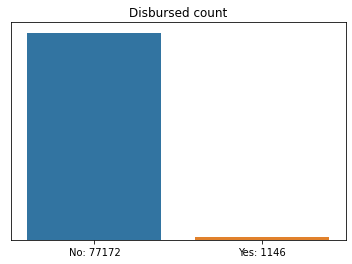

In [24]:

sns.barplot(x=[0,1], y=[y_train.size - y_train.sum(), y_train.sum()])
plt.xticks([0,1], labels=[f'No: {y_train.size - y_train.sum()}', f'Yes: {y_train.sum()}'])
plt.yticks([])
plt.title('Disbursed count')
plt.show()

**Significant imbalance in data will have to be adressed in modeling phase.**<br>
Stratified K-Folds cross-validator will be used to partially deal with this issue.

In [25]:
skf = StratifiedKFold(n_splits=5)

## Simple Tree Classifier
For interpretability reasons Decission Tree is a good choice when deciding about loan disbursal.

In [242]:
tree_pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('over', RandomOverSampler()),
    ('classifier', DecisionTreeClassifier())
])

search_space = {'classifier__min_samples_leaf': np.arange(4,64,4),
                'classifier__max_depth': np.arange(10,31,2)}

tree_grid = GridSearchCV(tree_pipe, search_space,
                    cv=skf,
                    scoring='roc_auc',
                    n_jobs=-1)

tree_grid.fit(X_train, y_train)
tree_grid.best_params_

{'classifier__max_depth': 10, 'classifier__min_samples_leaf': 56}

In [244]:
score = Scoring(tree_grid.best_estimator_, X_test, y_test, 'Test').check()
score.show()

Test ROC_AUC Score: 0.7933
Test Precision Score: 0.0395
Test Recall Score: 0.811
Test f1 Score: 0.0753
Test Balanced Accuracy Score: 0.7595


Scoring()

In [141]:
tree_pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('over', RandomOverSampler()),
    ('classifier', DecisionTreeClassifier(max_depth=10, min_samples_leaf=56))
])
tree_pipe.fit(X_train, y_train)
score_tree = Scoring(tree_pipe, X_test, y_test, 'Test').check()
score_tree.show()

Test ROC_AUC Score: 0.7949
Test Precision Score: 0.0389
Test Recall Score: 0.8031
Test f1 Score: 0.0742
Test Balanced Accuracy Score: 0.7547


Scoring()

## RFClassifier

First **'blind shot'** of hyperparameters.

In [231]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('oversampler', RandomOverSampler()),
    ('classifier', RandomForestClassifier(min_samples_leaf=50, n_jobs=-1))
])
pipe.fit(X_train, y_train)
score = Scoring(pipe, X_test, y_test, 'Test').check()
score.show()

Test ROC_AUC Score: 0.8569
Test Precision Score: 0.0597
Test Recall Score: 0.5984
Test f1 Score: 0.1086
Test Balanced Accuracy Score: 0.7295


Scoring()

In [230]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('over', RandomOverSampler(sampling_strategy=0.3)),
    ('classifier', BalancedRandomForestClassifier(min_samples_leaf=50, n_jobs=-1))
])
pipe.fit(X_train, y_train)
score = Scoring(pipe, X_test, y_test, 'Test').check()
score.show()

Test ROC_AUC Score: 0.8609
Test Precision Score: 0.0455
Test Recall Score: 0.7874
Test f1 Score: 0.0861
Test Balanced Accuracy Score: 0.7715


Scoring()

### Hyperparameter Search

In [228]:
RFC_pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('over', RandomOverSampler()),
    ('classifier', RandomForestClassifier())
])

search_space = [{'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [100,150,200],
                 'classifier__min_samples_leaf': [10,20,30,40],
                 'classifier__max_depth': [7,10,None]},
                {'classifier': [BalancedRandomForestClassifier(sampling_strategy='majority')],
                 'classifier__n_estimators': [100,150,200],
                 'classifier__min_samples_leaf': [10,20,30,40],
                 'classifier__max_depth': [7,10,None],
                 'over__sampling_strategy': [0.3,0.4]}]


RFC_grid = GridSearchCV(RFC_pipe, search_space,
                    cv=skf,
                    scoring='roc_auc',
                    n_jobs=-1)

RFC_grid.fit(X_train, y_train)
RFC_grid.best_params_

{'classifier': BalancedRandomForestClassifier(min_samples_leaf=30, n_estimators=200,
                                sampling_strategy='majority'),
 'classifier__max_depth': None,
 'classifier__min_samples_leaf': 30,
 'classifier__n_estimators': 200,
 'over__sampling_strategy': 0.4}

In [142]:
score_RFC = Scoring(RFC_grid.best_estimator_, X_test, y_test, 'Test').check()
score_RFC.show()

Test ROC_AUC Score: 0.864
Test Precision Score: 0.0551
Test Recall Score: 0.7087
Test f1 Score: 0.1022
Test Balanced Accuracy Score: 0.7643


Scoring()

In [42]:
# with open('RFC_grid.pkl', 'wb') as f:
#     pickle.dump(RFC_grid, f)

with open('RFC_grid.pkl', 'rb') as f:
    RFC_grid = pickle.load(f)

### Feature importance visualization

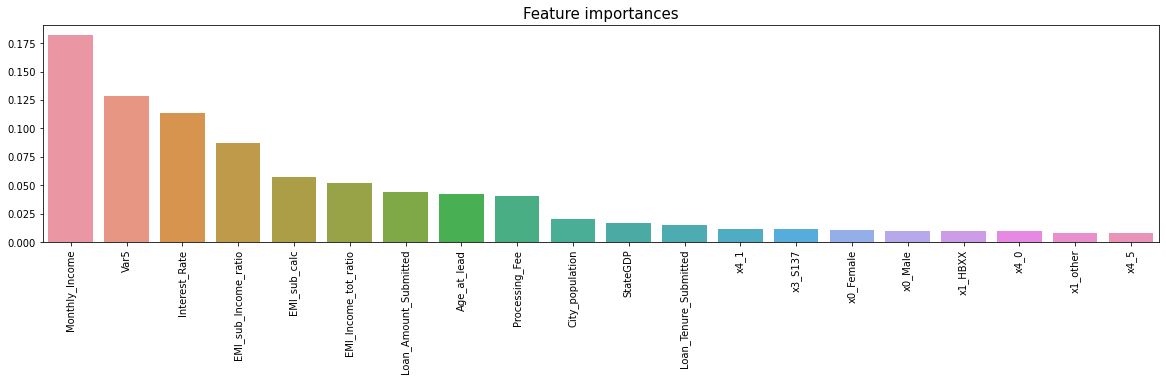

In [234]:
sel_pipe = RFC_grid.best_estimator_
feature_names = [*sel_pipe['preprocessing'].transformer_list[0][1]['cat_encoder'].get_feature_names(),
                *sel_pipe['preprocessing'].transformer_list[1][1]['dictionary'].get_feature_names(),
                *sel_pipe['preprocessing'].transformer_list[2][1]['date_manager'].get_feature_names(),
                *sel_pipe['preprocessing'].transformer_list[3][1]['money'].get_feature_names(),
                *sel_pipe['preprocessing'].transformer_list[4][1]['cat_encoder'].get_feature_names(),
                *sel_pipe['preprocessing'].transformer_list[5][1]['selector'].get_feature_names()]

f_imp = sel_pipe['classifier'].feature_importances_
stacked = np.vstack((f_imp, feature_names))
idxs = np.argsort(f_imp)[::-1][:20]

plt.figure(figsize=(20,4))
sns.barplot(x=stacked[1][idxs], y=stacked[0][idxs].astype(np.float))
plt.xticks(rotation=90)
# plt.ylabel('Feature importance')
plt.title('Feature importances', fontdict={'fontsize': 15})
plt.show()

## XGBoost

In [255]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('over', RandomOverSampler()),
    ('classifier', XGBClassifier(n_jobs=-1, use_label_encoder=False, eval_metric='logloss'))
])
pipe.fit(X_train, y_train)
score = Scoring(pipe, X_test, y_test, 'Test').check()
score.show()

Test ROC_AUC Score: 0.8242
Test Precision Score: 0.064
Test Recall Score: 0.5118
Test f1 Score: 0.1137
Test Balanced Accuracy Score: 0.7005


Scoring()

In [257]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('over', RandomOverSampler(sampling_strategy=.4)),
    ('classifier', BalancedBaggingClassifier(base_estimator=XGBClassifier(n_estimators=10, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'), n_estimators=80))
])
pipe.fit(X_train, y_train)
score = Scoring(pipe, X_test, y_test, 'Test').check()
score.show()

Test ROC_AUC Score: 0.859
Test Precision Score: 0.0433
Test Recall Score: 0.7717
Test f1 Score: 0.0821
Test Balanced Accuracy Score: 0.7597


Scoring()

### Hyperparameter Search

In [26]:
XGB_pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('over', RandomOverSampler()),
    ('classifier', BalancedBaggingClassifier(
        base_estimator=XGBClassifier(n_estimators=10, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'))
    )])

param_grid = {'classifier__base_estimator__n_estimators': ss.randint(5, 10), 
              'classifier__base_estimator__learning_rate': ss.uniform(0.01,1),
              'classifier__base_estimator__max_depth': ss.randint(5,15),
              'classifier__base_estimator__gamma': ss.uniform(0, 0.05),
              'classifier__n_estimators': [80,100,120,140],
              'over__sampling_strategy': ss.uniform(0.3,.5)}

XGB_optimizer = RandomizedSearchCV(XGB_pipe, param_grid, 
                               n_iter=50, 
                               cv=skf, 
                               n_jobs=-1,
                               scoring='roc_auc')
XGB_optimizer.fit(X_train, y_train)
XGB_optimizer.best_params_

{'classifier__base_estimator__gamma': 0.024337154865433266,
 'classifier__base_estimator__learning_rate': 0.5730172765715204,
 'classifier__base_estimator__max_depth': 5,
 'classifier__base_estimator__n_estimators': 7,
 'classifier__n_estimators': 100,
 'over__sampling_strategy': 0.5786782603706946}

In [143]:
score_XGB = Scoring(XGB_optimizer, X_test, y_test, 'Test').check()
score_XGB.show()

Test ROC_AUC Score: 0.8447
Test Precision Score: 0.0418
Test Recall Score: 0.7638
Test f1 Score: 0.0793
Test Balanced Accuracy Score: 0.7523


Scoring()

In [28]:
# with open('XGB_optimizer.pkl', 'wb') as f:
#     pickle.dump(XGB_optimizer, f)

with open('XGB_optimizer.pkl', 'rb') as f:
    XGB_optimizer = pickle.load(f)

## Bagged GradientBoosting

In [132]:
GBC_pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('over', RandomOverSampler()),
    ('classifier', BalancedBaggingClassifier(
        base_estimator=GradientBoostingClassifier())
    )])

param_grid = {'classifier__base_estimator__n_estimators': ss.randint(5, 10), 
              'classifier__base_estimator__learning_rate': ss.uniform(0.01,.3),
              'classifier__base_estimator__max_depth': ss.randint(3,8),
              'classifier__base_estimator__subsample': ss.uniform(.8, 1),
              'classifier__base_estimator__min_samples_leaf': np.arange(10,70,5),
              'classifier__n_estimators': [80,100,120,140],
              'over__sampling_strategy': ss.uniform(0.3,.5)}

GBC_optimizer = RandomizedSearchCV(GBC_pipe, param_grid, 
                               n_iter=50, 
                               cv=skf, 
                               n_jobs=-1,
                               scoring='roc_auc')
GBC_optimizer.fit(X_train, y_train)
GBC_optimizer.best_params_

c:\users\antos\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.8327448         nan 0.80938649        nan        nan
 0.84031246        nan        nan        nan 0.83620129 0.82267119
        nan        nan 0.83583459        nan        nan        nan
        nan        nan        nan        nan 0.8415124         nan
        nan        nan        nan        nan        nan 0.82764257
        nan 0.83125375        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.83086957        nan        nan        nan
        nan        nan]
  warnings.warn(


{'classifier__base_estimator__learning_rate': 0.20745574849428047,
 'classifier__base_estimator__max_depth': 6,
 'classifier__base_estimator__min_samples_leaf': 30,
 'classifier__base_estimator__n_estimators': 8,
 'classifier__base_estimator__subsample': 0.9489400990599769,
 'classifier__n_estimators': 100,
 'over__sampling_strategy': 0.609246437938581}

In [144]:
score_GBC = Scoring(GBC_optimizer, X_test, y_test, 'Test').check()
score_GBC.show()

Test ROC_AUC Score: 0.8531
Test Precision Score: 0.0432
Test Recall Score: 0.8031
Test f1 Score: 0.0819
Test Balanced Accuracy Score: 0.7697


Scoring()

In [134]:
# with open('GBC_optimizer.pkl', 'wb') as f:
#     pickle.dump(GBC_optimizer, f)

with open('GBC_optimizer.pkl', 'rb') as f:
    GBC_optimizer = pickle.load(f)

## Bagged AdaBoost

### Hyperparameter Search

In [135]:
RUSB_pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('over', RandomOverSampler()),
    ('classifier', RUSBoostClassifier())
])

param_grid = {'classifier__n_estimators': ss.randint(50,200), 
              'classifier__learning_rate': ss.uniform(0.01,1),
              'over__sampling_strategy': ss.uniform(0.3,.5)}

RUSB_optimizer = RandomizedSearchCV(RUSB_pipe, param_grid, 
                               n_iter=50, 
                               cv=skf, 
                               n_jobs=-1,
                               scoring='roc_auc')
RUSB_optimizer.fit(X_train, y_train)
RUSB_optimizer.best_params_

{'classifier__learning_rate': 0.14827278306546443,
 'classifier__n_estimators': 142,
 'over__sampling_strategy': 0.4490380040735202}

In [145]:
score_RUSB = Scoring(RUSB_optimizer, X_test, y_test, 'Test').check()
score_RUSB.show()

Test ROC_AUC Score: 0.8389
Test Precision Score: 0.0383
Test Recall Score: 0.8031
Test f1 Score: 0.0732
Test Balanced Accuracy Score: 0.7524


Scoring()

In [137]:
# with open('RUSB_optimizer.pkl', 'wb') as f:
#     pickle.dump(RUSB_optimizer, f)

with open('RUSB_optimizer.pkl', 'rb') as f:
    RUSB_optimizer = pickle.load(f)

# Results Summary and Conclusions

In [138]:
col_n = np.array(score_tree.metric_scores)[:,1]
score_sf = pd.DataFrame(columns=col_n)
vals = np.array(score_tree.metric_scores)[:,0]
score_sf.loc['Decission Tree'] = vals
vals = np.array(score_RFC.metric_scores)[:,0]
score_sf.loc['RFC'] = vals
vals = np.array(score_XGB.metric_scores)[:,0]
score_sf.loc['XGBoost'] = vals
vals = np.array(score_GBC.metric_scores)[:,0]
score_sf.loc['Gradiet Boosting'] = vals
vals = np.array(score_RUSB.metric_scores)[:,0]
score_sf.loc['AdaBoost'] = vals

In [139]:
df = score_sf.applymap(float)
df.style.background_gradient(cmap='coolwarm', low=.5, high=.1).set_precision(3)

,ROC_AUC,Precision,Recall,f1,Balanced Accuracy
Decission Tree,0.792,0.041,0.827,0.078,0.770
RFC,0.864,0.055,0.709,0.102,0.764
XGBoost,0.845,0.042,0.764,0.079,0.752
Gradiet Boosting,0.853,0.043,0.803,0.082,0.770
AdaBoost,0.839,0.038,0.803,0.073,0.752


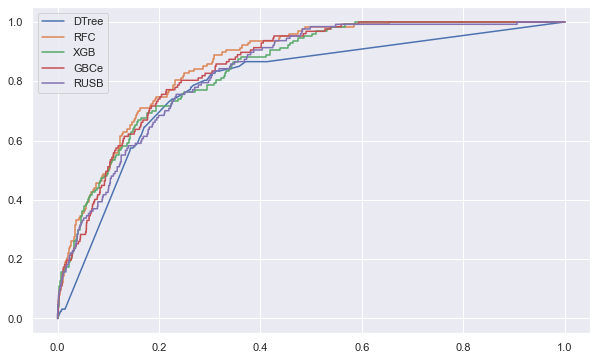

In [155]:
sns.set()
plt.figure(figsize=(10,6))
fpr, tpr, _ = metrics.roc_curve(y_test, score_tree.y_pred)
plt.plot(fpr, tpr, label='DTree')
fpr, tpr, _ = metrics.roc_curve(y_test, score_RFC.y_pred)
plt.plot(fpr, tpr, label='RFC')
fpr, tpr, _ = metrics.roc_curve(y_test, score_XGB.y_pred)
plt.plot(fpr, tpr, label='XGB')
fpr, tpr, _ = metrics.roc_curve(y_test, score_GBC.y_pred)
plt.plot(fpr, tpr, label='GBCe')
fpr, tpr, _ = metrics.roc_curve(y_test, score_RUSB.y_pred)
plt.plot(fpr, tpr, label='RUSB')
plt.legend()
plt.show()

Considering the results obtained, RFC performs best (scoring on ROC_AUC).<br>
It is likely that with better optimization of the hyperparameters, the quality of the remaining classifiers would be slightly better.<br>
The analysis performed is a very general check of the fit of the classification algorithms to the given dataset.

With such an unbalanced dataset using measures other than ROC_AUC, it would be important to consider the choice of threshold (corresponding to needs).